
### Opening a New Gym/Fitness Center in Mumbai, Maharashtra

* Build a dataframe of neighborhoods in Mumbai, Maharashtra by web scraping the data from Wikipedia page
* Get the geographical coordinates of the neighborhoods
* Obtain the venue data for the neighborhoods from Foursquare API
* Explore and cluster the neighborhoods
* Select the best cluster to open a new bakery

In [1]:
#installing required packeges 
!pip install beautifulsoup4
!pip install requests
!pip install geopy
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



### Import libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.pyplot as plt

print("Libraries imported.")

Libraries imported.


### Srape data from wikipedia page into Dataframe

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
df =pd.read_html(url)[0]
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


Area                 Location   Latitude  Longitude
0            Amboli  Andheri,Western Suburbs  19.129300  72.843400
1  Chakala, Andheri          Western Suburbs  19.111388  72.860833
2        D.N. Nagar  Andheri,Western Suburbs  19.124085  72.831373
3    Four Bungalows  Andheri,Western Suburbs  19.124714  72.827210
4       Lokhandwala  Andheri,Western Suburbs  19.130815  72.829270

In [4]:
#df.drop(['Location'], axis=1, inplace=True)
df.rename(columns={'Area':'Neighborhood'}, inplace=True)
print(df.shape)
df.head()

(93, 4)


Neighborhood                 Location   Latitude  Longitude
0            Amboli  Andheri,Western Suburbs  19.129300  72.843400
1  Chakala, Andheri          Western Suburbs  19.111388  72.860833
2        D.N. Nagar  Andheri,Western Suburbs  19.124085  72.831373
3    Four Bungalows  Andheri,Western Suburbs  19.124714  72.827210
4       Lokhandwala  Andheri,Western Suburbs  19.130815  72.829270

In [5]:
df.info()
#So our data has no null values. Great

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  93 non-null     object 
 1   Location      93 non-null     object 
 2   Latitude      93 non-null     float64
 3   Longitude     93 non-null     float64
dtypes: float64(2), object(2)
memory usage: 3.0+ KB


### Create a map of Mumbai with neighborhoods superimposed on top

In [5]:
address = 'Mumbai, Maharashtra'

geolocator = Nominatim(user_agent='mumbai-exp')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai, Maharashtra is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai, Maharashtra is 19.0759899, 72.8773928.


In [6]:
# create map of Mumbai using latitude and longitude values
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_mum)  
    
map_mum

### Use the Foursquare API to explore the neighborhoods

In [7]:
CLIENT_ID = 'QR54WWUGIEHPMQCKZOGBMVEB4H2BXJUOEHAB43FNSROO5PXB' # your Foursquare ID
CLIENT_SECRET = 'F5F3GZ1IHJ0F3H01B2TIR5THPPQZTSJMHZA2EM1DS0LG1YON' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Now, let's get the top 100 venues that are within a radius of 2000 meters.

In [8]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    print(results)
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

    

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5174e2be498e39cf0d1c20cb', 'name': 'Shawarma Factory', 'location': {'address': 'Dadabhai Road', 'crossStreet': 'Off JP Road, Near Navrang Cinema', 'lat': 19.124590572173467, 'lng': 72.8403981304492, 'labeledLatLngs': [{'label': 'display', 'lat': 19.124590572173467, 'lng': 72.8403981304492}], 'distance': 611, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Dadabhai Road (Off JP Road, Near Navrang Cinema)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10b941735', 'name': 'Falafel Restaurant', 'pluralName': 'Falafel Restaurants', 'shortName': 'Falafel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/falafel_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5174e2be498e39cf0d1c20cb-0'}, {'reasons': {

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc78f5793bdeee1848337ae', 'name': 'ITC Maratha', 'location': {'address': 'Sahar Airport Road, Near International Airport, Andheri', 'lat': 19.10402335643933, 'lng': 72.86963760852814, 'labeledLatLngs': [{'label': 'display', 'lat': 19.10402335643933, 'lng': 72.86963760852814}], 'distance': 1236, 'postalCode': '400099', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Sahar Airport Road, Near International Airport, Andheri', 'Mumbai 400099', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bc78f5793bdeee1848337ae-0'}, {'reasons': {'co

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cc1d37c3d7fa1cd0de39a5f', 'name': "Joey's Pizza", 'location': {'address': '6 & 7, Upvan Bldg, Behind Indian Oil Colony, D N Nagar, New Lic Colony Rd, Andheri (W)', 'crossStreet': 'Andheri', 'lat': 19.126762155150107, 'lng': 72.83000121236746, 'labeledLatLngs': [{'label': 'display', 'lat': 19.126762155150107, 'lng': 72.83000121236746}], 'distance': 331, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['6 & 7, Upvan Bldg, Behind Indian Oil Colony, D N Nagar, New Lic Colony Rd, Andheri (W) (Andheri)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'g

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cc1d37c3d7fa1cd0de39a5f', 'name': "Joey's Pizza", 'location': {'address': '6 & 7, Upvan Bldg, Behind Indian Oil Colony, D N Nagar, New Lic Colony Rd, Andheri (W)', 'crossStreet': 'Andheri', 'lat': 19.126762155150107, 'lng': 72.83000121236746, 'labeledLatLngs': [{'label': 'display', 'lat': 19.126762155150107, 'lng': 72.83000121236746}], 'distance': 371, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['6 & 7, Upvan Bldg, Behind Indian Oil Colony, D N Nagar, New Lic Colony Rd, Andheri (W) (Andheri)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'g

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cc1d37c3d7fa1cd0de39a5f', 'name': "Joey's Pizza", 'location': {'address': '6 & 7, Upvan Bldg, Behind Indian Oil Colony, D N Nagar, New Lic Colony Rd, Andheri (W)', 'crossStreet': 'Andheri', 'lat': 19.126762155150107, 'lng': 72.83000121236746, 'labeledLatLngs': [{'label': 'display', 'lat': 19.126762155150107, 'lng': 72.83000121236746}], 'distance': 457, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['6 & 7, Upvan Bldg, Behind Indian Oil Colony, D N Nagar, New Lic Colony Rd, Andheri (W) (Andheri)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'g

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d4e763d8af6721e86aa1088', 'name': 'Benzys', 'location': {'address': 'Marol Maroshi Road', 'crossStreet': 'Vijay Nagar, Andheri East', 'lat': 19.120164868254616, 'lng': 72.88009965676395, 'labeledLatLngs': [{'label': 'display', 'lat': 19.120164868254616, 'lng': 72.88009965676395}], 'distance': 297, 'postalCode': '560059', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Marol Maroshi Road (Vijay Nagar, Andheri East)', 'Mumbai 560059', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d4e763d8af6721e86aa1088-0'}

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc78f5793bdeee1848337ae', 'name': 'ITC Maratha', 'location': {'address': 'Sahar Airport Road, Near International Airport, Andheri', 'lat': 19.10402335643933, 'lng': 72.86963760852814, 'labeledLatLngs': [{'label': 'display', 'lat': 19.10402335643933, 'lng': 72.86963760852814}], 'distance': 625, 'postalCode': '400099', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Sahar Airport Road, Near International Airport, Andheri', 'Mumbai 400099', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bc78f5793bdeee1848337ae-0'}, {'reasons': {'cou

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a43d67be55d8b053262347a', 'name': 'Tanjore Tiffin Room', 'location': {'address': 'Jewel Shopping Centre', 'lat': 19.128438, 'lng': 72.81715, 'labeledLatLngs': [{'label': 'display', 'lat': 19.128438, 'lng': 72.81715}], 'distance': 69, 'postalCode': '400061', 'cc': 'IN', 'neighborhood': 'Andheri', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Jewel Shopping Centre', 'Mumbai 400061', 'Mahārāshtra', 'India']}, 'categories': [{'id': '54135bf5e4b08f3d2429dfde', 'name': 'South Indian Restaurant', 'pluralName': 'South Indian Restaurants', 'shortName': 'South Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5a43d67be55d8b053262347a-0'}, {'reasons': {'count': 0, 'items': [{'summa

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d8f964a520f8a322e3', 'name': 'Urban Tadka', 'location': {'address': 'Juhu-Versova Road', 'crossStreet': 'Juhu Versova Link Road', 'lat': 19.12701051542414, 'lng': 72.82183256427811, 'labeledLatLngs': [{'label': 'display', 'lat': 19.12701051542414, 'lng': 72.82183256427811}], 'distance': 803, 'postalCode': '400 061', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Juhu-Versova Road (Juhu Versova Link Road)', 'Mumbai 400 061', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d8f964a520f8a322e3-0'}, {

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bebab2aca97d13ae1aa6c77', 'name': 'GCC Club', 'location': {'address': 'Mira Rd East', 'crossStreet': 'Hatkesh', 'lat': 19.282988047064674, 'lng': 72.8782589990776, 'labeledLatLngs': [{'label': 'display', 'lat': 19.282988047064674, 'lng': 72.8782589990776}], 'distance': 762, 'postalCode': '401107', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Mira Rd East (Hatkesh)', 'Mumbai 401107', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d175941735', 'name': 'Gym / Fitness Center', 'pluralName': 'Gyms or Fitness Centers', 'shortName': 'Gym / Fitness', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bebab2aca97d13ae1aa6c77-0'}, {'reasons': {'count': 0, 'item

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d5fe4b3ef378cfaa5cf75a6', 'name': "Domino's Pizza", 'location': {'address': 'Shop no2, janaki heritage', 'lat': 19.295, 'lng': 72.849, 'labeledLatLngs': [{'label': 'display', 'lat': 19.295, 'lng': 72.849}], 'distance': 566, 'postalCode': '401101', 'cc': 'IN', 'city': 'Thāne', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Shop no2, janaki heritage', 'Thāne 401101', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d5fe4b3ef378cfaa5cf75a6-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globa

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d458176e198721e6c8dc68b', 'name': 'Dariya Kinara', 'location': {'address': 'Gorai', 'lat': 19.26331257018824, 'lng': 72.78466177372718, 'labeledLatLngs': [{'label': 'display', 'lat': 19.26331257018824, 'lng': 72.78466177372718}], 'distance': 1857, 'cc': 'IN', 'city': 'Mira Bhayandar', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Gorai', 'Mira Bhayandar', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d458176e198721e6c8dc68b-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5167b86fe4b0cda682a9ebaa', 'name': "Godrej Nature's Basket", 'location': {'address': '56 Hill Road', 'crossStreet': 'Bandra West', 'lat': 19.055509463847304, 'lng': 72.83193507717596, 'labeledLatLngs': [{'label': 'display', 'lat': 19.055509463847304, 'lng': 72.83193507717596}], 'distance': 60, 'postalCode': '400050', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['56 Hill Road (Bandra West)', 'Mumbai 400050', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1f5941735', 'name': 'Gourmet Shop', 'pluralName': 'Gourmet Shops', 'shortName': 'Gourmet', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_gourmet_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5167b86fe4b0cda682a9ebaa-0'}, {'reasons': {'count': 0, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b812df7f964a5208f9930e3', 'name': 'Candies', 'location': {'address': 'Union Park, Bandra West', 'crossStreet': 'Near Carter Road', 'lat': 19.070288312673544, 'lng': 72.82624472801321, 'labeledLatLngs': [{'label': 'display', 'lat': 19.070288312673544, 'lng': 72.82624472801321}], 'distance': 256, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Union Park, Bandra West (Near Carter Road)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b812df7f964a5208f9930e3-0'}, {'reasons': {'count': 0, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bd71b9f637ba593624bf970', 'name': 'Fizzy', 'location': {'address': 'opposite Mary immaculate school', 'crossStreet': 'mandpeshwar road', 'lat': 19.24829552302955, 'lng': 72.8532963754703, 'labeledLatLngs': [{'label': 'display', 'lat': 19.24829552302955, 'lng': 72.8532963754703}], 'distance': 390, 'postalCode': '400103', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['opposite Mary immaculate school (mandpeshwar road)', 'Mumbai 400103', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d112941735', 'name': 'Juice Bar', 'pluralName': 'Juice Bars', 'shortName': 'Juice Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bd71b9f637ba593624bf970-0'}, {'reas

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cf158527bf3b60c1a255f7f', 'name': 'Gorai Beach', 'location': {'address': 'Gorai Koliwada Village', 'crossStreet': 'Borivali West', 'lat': 19.245165386092022, 'lng': 72.7819955289039, 'labeledLatLngs': [{'label': 'display', 'lat': 19.245165386092022, 'lng': 72.7819955289039}], 'distance': 544, 'postalCode': '400092', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Gorai Koliwada Village (Borivali West)', 'Mumbai 400092', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e2941735', 'name': 'Beach', 'pluralName': 'Beaches', 'shortName': 'Beach', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4cf158527bf3b60c1a255f7f-0'}, {'reasons': {'count': 0, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d1f964a520e6a222e3', 'name': 'Film City', 'location': {'address': 'Dadasaheb Phalke Chitranagri Goregaon (East), Mumbai - 400065.', 'lat': 19.160959963809262, 'lng': 72.88617676755688, 'labeledLatLngs': [{'label': 'display', 'lat': 19.160959963809262, 'lng': 72.88617676755688}], 'distance': 1463, 'postalCode': '400 063', 'cc': 'IN', 'neighborhood': 'Goregaon', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Dadasaheb Phalke Chitranagri Goregaon (East), Mumbai - 400065.', 'Mumbai 400 063', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d171941735', 'name': 'Event Space', 'pluralName': 'Event Spaces', 'shortName': 'Event Space', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/eventspace_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587e3f964a520c7a522e3', 'name': 'Mad Over Donuts', 'location': {'address': 'Level 2, Food Court, Inorbit Mall, Link Road', 'crossStreet': 'Link Road', 'lat': 19.173075095778774, 'lng': 72.83568481546911, 'labeledLatLngs': [{'label': 'display', 'lat': 19.173075095778774, 'lng': 72.83568481546911}], 'distance': 731, 'postalCode': '400064', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Level 2, Food Court, Inorbit Mall, Link Road (Link Road)', 'Mumbai 400064', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d148941735', 'name': 'Donut Shop', 'pluralName': 'Donut Shops', 'shortName': 'Donuts', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/donuts_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587e3f964a

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587e2f964a52095a522e3', 'name': 'Merwans Cake shop', 'location': {'address': 'Near Andheri Station, SV Road', 'crossStreet': 'Andheri West', 'lat': 19.119300215885474, 'lng': 72.84541776016009, 'labeledLatLngs': [{'label': 'display', 'lat': 19.119300215885474, 'lng': 72.84541776016009}], 'distance': 488, 'postalCode': '400 058', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Near Andheri Station, SV Road (Andheri West)', 'Mumbai 400 058', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587e2f964a52095a522e3-0'}, {'reasons'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '522c3e1011d20c34ea55b14c', 'name': 'Starbucks', 'location': {'address': 'Bawa International', 'crossStreet': 'Juhu Tara Rd.', 'lat': 19.100479378755946, 'lng': 72.82743812573055, 'labeledLatLngs': [{'label': 'display', 'lat': 19.100479378755946, 'lng': 72.82743812573055}], 'distance': 274, 'postalCode': '400049', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Bawa International (Juhu Tara Rd.)', 'Mumbai 400049', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-522c3e1011d20c34ea55b14c-0'}, {'reasons': {'count': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '52f38fb511d2024e73897bd1', 'name': 'Starbucks', 'location': {'address': 'B-2, V Souk, Mahavir Nagar, Kandivali West', 'crossStreet': 'Mahavir Nagar, Kandivali West,', 'lat': 19.21292730822335, 'lng': 72.8422918067928, 'labeledLatLngs': [{'label': 'display', 'lat': 19.21292730822335, 'lng': 72.8422918067928}], 'distance': 1283, 'postalCode': '400067', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['B-2, V Souk, Mahavir Nagar, Kandivali West (Mahavir Nagar, Kandivali West,)', 'Mumbai 400067', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4dc196c8fa764d03ea0230a1', 'name': 'Rajubhai Dhoklawala', 'location': {'crossStreet': '4 cross MG Road', 'lat': 19.206948221745883, 'lng': 72.84218821670724, 'labeledLatLngs': [{'label': 'display', 'lat': 19.206948221745883, 'lng': 72.84218821670724}], 'distance': 549, 'postalCode': '400067', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['4 cross MG Road', 'Mumbai 400067', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4d4b7105d754a06374d81259', 'name': 'Food', 'pluralName': 'Food', 'shortName': 'Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4dc196c8fa764d03ea0230a1-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '52f38fb511d2024e73897bd1', 'name': 'Starbucks', 'location': {'address': 'B-2, V Souk, Mahavir Nagar, Kandivali West', 'crossStreet': 'Mahavir Nagar, Kandivali West,', 'lat': 19.21292730822335, 'lng': 72.8422918067928, 'labeledLatLngs': [{'label': 'display', 'lat': 19.21292730822335, 'lng': 72.8422918067928}], 'distance': 185, 'postalCode': '400067', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['B-2, V Souk, Mahavir Nagar, Kandivali West (Mahavir Nagar, Kandivali West,)', 'Mumbai 400067', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4dd3e445ae6009a5122a6f64', 'name': 'Pizza Hut', 'location': {'address': '17, Thakur Cinema and Welfare Centre, Thakur Village, Kandivali East, Mumbai, MH 400101', 'crossStreet': 'Kandivali East', 'lat': 19.208619587438534, 'lng': 72.87260273282945, 'labeledLatLngs': [{'label': 'display', 'lat': 19.208619587438534, 'lng': 72.87260273282945}], 'distance': 180, 'postalCode': '400101', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['17, Thakur Cinema and Welfare Centre, Thakur Village, Kandivali East, Mumbai, MH 400101 (Kandivali East)', 'Mumbai 400101', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5496e94e498e349305d81639', 'name': 'Bombay Salad Co.', 'location': {'address': 'Rita Apartment, 16th road, Lane next to Mini Punjab', 'crossStreet': 'Opposite syndicate bank', 'lat': 19.064715341256164, 'lng': 72.83091998224552, 'labeledLatLngs': [{'label': 'display', 'lat': 19.064715341256164, 'lng': 72.83091998224552}], 'distance': 271, 'postalCode': '400050', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Rita Apartment, 16th road, Lane next to Mini Punjab (Opposite syndicate bank)', 'Mumbai 400050', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1bd941735', 'name': 'Salad Place', 'pluralName': 'Salad Places', 'shortName': 'Salad', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/salad_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'grou

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '56345dce498e87c16cbd1843', 'name': 'Khar Social', 'location': {'address': 'Behind Ramee', 'crossStreet': 'SV Road', 'lat': 19.068243423955007, 'lng': 72.83802654231332, 'labeledLatLngs': [{'label': 'display', 'lat': 19.068243423955007, 'lng': 72.83802654231332}], 'distance': 215, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Behind Ramee (SV Road)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-56345dce498e87c16cbd1843-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bf7c3695efe2d7fef796934', 'name': 'PVR Cinemas', 'location': {'address': 'Oberoi Mall, Off Western Express Highway', 'crossStreet': 'Goregaon (East)', 'lat': 19.174015546303206, 'lng': 72.86048474236073, 'labeledLatLngs': [{'label': 'display', 'lat': 19.174015546303206, 'lng': 72.86048474236073}], 'distance': 532, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Oberoi Mall, Off Western Express Highway (Goregaon (East))', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d180941735', 'name': 'Multiplex', 'pluralName': 'Multiplexes', 'shortName': 'Cineplex', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bf7c3695efe2d7fef79693

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cd16350de0f6dcb13947063', 'name': 'Joeys Pizza', 'location': {'address': 'Chincoli Bunder Signal', 'crossStreet': 'Malad west', 'lat': 19.179429315681627, 'lng': 72.83746679187674, 'labeledLatLngs': [{'label': 'display', 'lat': 19.179429315681627, 'lng': 72.83746679187674}], 'distance': 685, 'postalCode': '400064', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Chincoli Bunder Signal (Malad west)', 'Mumbai 400064', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4cd16350de0f6dcb13947063-0'}, {'reasons': {'count': 0, 'ite

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cda8dc7b34e60fc88e64399', 'name': 'Sandwizzaa', 'location': {'address': 'Kanu Desai Rd, Station Rd, Santacruz (W)', 'lat': 19.08070030358886, 'lng': 72.84041405733342, 'labeledLatLngs': [{'label': 'display', 'lat': 19.08070030358886, 'lng': 72.84041405733342}], 'distance': 148, 'postalCode': '400054', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Kanu Desai Rd, Station Rd, Santacruz (W)', 'Mumbai 400054', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1c5941735', 'name': 'Sandwich Place', 'pluralName': 'Sandwich Places', 'shortName': 'Sandwiches', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4cda8dc7b34e60fc88e64399-0'}, {'reasons': {'count': 0, 'it

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bd06cdd41b9ef3bb301fae5', 'name': 'Naigaon Railway Station', 'location': {'address': 'Naigaon Station', 'crossStreet': 'Station Road', 'lat': 19.351213966102584, 'lng': 72.84632921218872, 'labeledLatLngs': [{'label': 'display', 'lat': 19.351213966102584, 'lng': 72.84632921218872}], 'distance': 28, 'postalCode': '401201', 'cc': 'IN', 'city': 'Vasai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Naigaon Station (Station Road)', 'Vasai 401201', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d129951735', 'name': 'Train Station', 'pluralName': 'Train Stations', 'shortName': 'Train Station', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/trainstation_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bd06cdd41b9ef3bb301fae5-0'}, {'reasons

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '566fe377498eec2123639ac0', 'name': "McDonald's", 'location': {'address': 'Virar', 'lat': 19.474018071586887, 'lng': 72.8048423487713, 'labeledLatLngs': [{'label': 'display', 'lat': 19.474018071586887, 'lng': 72.8048423487713}], 'distance': 677, 'cc': 'IN', 'country': 'India', 'formattedAddress': ['Virar', 'India']}, 'categories': [{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-566fe377498eec2123639ac0-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d776e6fa32ca1cdb98a1adb', 'na

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5353bd55498ed44d14437bd3', 'name': 'Naturals', 'location': {'address': 'Next to ONGC', 'crossStreet': 'near irla', 'lat': 19.11120350275779, 'lng': 72.83725536561151, 'labeledLatLngs': [{'label': 'display', 'lat': 19.11120350275779, 'lng': 72.83725536561151}], 'distance': 360, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Next to ONGC (near irla)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1c9941735', 'name': 'Ice Cream Shop', 'pluralName': 'Ice Cream Shops', 'shortName': 'Ice Cream', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5353bd55498ed44d14437bd3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'ty

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '522c3e1011d20c34ea55b14c', 'name': 'Starbucks', 'location': {'address': 'Bawa International', 'crossStreet': 'Juhu Tara Rd.', 'lat': 19.100479378755946, 'lng': 72.82743812573055, 'labeledLatLngs': [{'label': 'display', 'lat': 19.100479378755946, 'lng': 72.82743812573055}], 'distance': 274, 'postalCode': '400049', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Bawa International (Juhu Tara Rd.)', 'Mumbai 400049', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-522c3e1011d20c34ea55b14c-0'}, {'reasons': {'count': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4dc7d797c65b89d3caa7745e', 'name': 'METRO Cash & Carry', 'location': {'address': 'Ground Floor, Neptune Magnet Mall', 'crossStreet': 'L.B.S. Marg', 'lat': 19.141545143071497, 'lng': 72.93186019295543, 'labeledLatLngs': [{'label': 'display', 'lat': 19.141545143071497, 'lng': 72.93186019295543}], 'distance': 260, 'postalCode': '400078', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Ground Floor, Neptune Magnet Mall (L.B.S. Marg)', 'Mumbai 400078', 'Mahārāshtra', 'India']}, 'categories': [{'id': '52f2ab2ebcbc57f1066b8b42', 'name': 'Big Box Store', 'pluralName': 'Big Box Stores', 'shortName': 'Big Box Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4dc7d797c65b8

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b27c85ff964a520dc8924e3', 'name': 'R City Mall', 'location': {'address': 'Ghatkopar', 'crossStreet': 'L.B.S Rd.', 'lat': 19.09932003159513, 'lng': 72.91671410367032, 'labeledLatLngs': [{'label': 'display', 'lat': 19.09932003159513, 'lng': 72.91671410367032}], 'distance': 510, 'postalCode': '400086', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Ghatkopar (L.B.S Rd.)', 'Mumbai 400086', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1fd941735', 'name': 'Shopping Mall', 'pluralName': 'Shopping Malls', 'shortName': 'Mall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '74640952'}}, 'referralId': 'e-0-4b27c85ff964a520dc8924e3-0'}, {'reasons': {'count': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '506c245be889751dc706f806', 'name': 'Mad Over Donuts', 'location': {'address': 'R-City Mall, Level 3, LBS Road, Ghatkopar West', 'lat': 19.08781197164128, 'lng': 72.90490865707397, 'labeledLatLngs': [{'label': 'display', 'lat': 19.08781197164128, 'lng': 72.90490865707397}], 'distance': 543, 'postalCode': '400086', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['R-City Mall, Level 3, LBS Road, Ghatkopar West', 'Mumbai 400086', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d148941735', 'name': 'Donut Shop', 'pluralName': 'Donut Shops', 'shortName': 'Donuts', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/donuts_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-506c245be889751dc706f806-0'}, {'reasons': {'count':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b4c8f5df964a5201cb626e3', 'name': 'Khau Galli', 'location': {'address': 'MG Road', 'crossStreet': 'Ghatkopar East', 'lat': 19.075307078374436, 'lng': 72.90528180465846, 'labeledLatLngs': [{'label': 'display', 'lat': 19.075307078374436, 'lng': 72.90528180465846}], 'distance': 720, 'postalCode': '400077', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['MG Road (Ghatkopar East)', 'Mumbai 400077', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1cb941735', 'name': 'Food Truck', 'pluralName': 'Food Trucks', 'shortName': 'Food Truck', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/streetfood_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b4c8f5df964a5201cb626e3-0'}, {'reasons': {'count': 0, 'items': [{'summary

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4dd0cc2fd4c065592fb77af8', 'name': 'Gopalas', 'location': {'address': 'LBS Marg', 'crossStreet': 'kanjurmarg (west)', 'lat': 19.13101751349966, 'lng': 72.9267761512571, 'labeledLatLngs': [{'label': 'display', 'lat': 19.13101751349966, 'lng': 72.9267761512571}], 'distance': 1395, 'postalCode': '400078', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['LBS Marg (kanjurmarg (west))', 'Mumbai 400078', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4dd0cc2fd4c065592fb77af8-0'}, {'reasons': {'count': 0, 'items': [{'sum

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '52050132498e5bedb767dca6', 'name': 'Kelgeri Lake', 'location': {'address': 'Kelgeri Lake', 'lat': 15.453607446775452, 'lng': 74.9871450992504, 'labeledLatLngs': [{'label': 'display', 'lat': 15.453607446775452, 'lng': 74.9871450992504}], 'distance': 1641, 'cc': 'IN', 'city': 'Dharwad', 'state': 'Karnātaka', 'country': 'India', 'formattedAddress': ['Kelgeri Lake', 'Dharwad', 'Karnātaka', 'India']}, 'categories': [{'id': '4bf58dd8d48988d161941735', 'name': 'Lake', 'pluralName': 'Lakes', 'shortName': 'Lake', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/lake_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-52050132498e5bedb767dca6-0'}]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5107ff0ce4b05e493f979b9a', 'name': 'Mehman Nawazi', 'location': {'address': 'NC foods, Supreme Business Park , A wing, 8th Floor, Hiranandani Gardens', 'crossStreet': 'Powai', 'lat': 19.11148457554709, 'lng': 72.90899993707585, 'labeledLatLngs': [{'label': 'display', 'lat': 19.11148457554709, 'lng': 72.90899993707585}], 'distance': 960, 'postalCode': '400076', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['NC foods, Supreme Business Park , A wing, 8th Floor, Hiranandani Gardens (Powai)', 'Mumbai 400076', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'c

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50f63f31e4b050d06e1cb448', 'name': 'Starbucks', 'location': {'address': 'G2, Prudential Building, Hiranandani Business Park', 'crossStreet': 'Powai', 'lat': 19.116317363005052, 'lng': 72.90970026946678, 'labeledLatLngs': [{'label': 'display', 'lat': 19.116317363005052, 'lng': 72.90970026946678}], 'distance': 368, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['G2, Prudential Building, Hiranandani Business Park (Powai)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-50f63f31e4b050d06e1cb448-0'}, {'rea

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d903d55c479a35d0cad6d97', 'name': 'Gulmohar cafeteria', 'location': {'address': 'IIT Bombay', 'crossStreet': 'Powai', 'lat': 19.13007030096963, 'lng': 72.91531039648797, 'labeledLatLngs': [{'label': 'display', 'lat': 19.13007030096963, 'lng': 72.91531039648797}], 'distance': 396, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['IIT Bombay (Powai)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d903d55c479a35d0cad6d97-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'typ

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50950f23e4b0578aae7a7a00', 'name': 'PVR Cinemas', 'location': {'address': 'Phoenix Market City', 'crossStreet': 'Kurla', 'lat': 19.08664273439014, 'lng': 72.88983942558215, 'labeledLatLngs': [{'label': 'display', 'lat': 19.08664273439014, 'lng': 72.88983942558215}], 'distance': 983, 'postalCode': '400001', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Phoenix Market City (Kurla)', 'Mumbai 400001', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d17f941735', 'name': 'Movie Theater', 'pluralName': 'Movie Theaters', 'shortName': 'Movie Theater', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-50950f23e4b0578aae7a7a00-0'}, {'reasons': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e2149ecd22d0a3f59f6a6bf', 'name': 'Moksha', 'location': {'address': '247 Park', 'crossStreet': 'Vikhroli', 'lat': 19.120012364966584, 'lng': 72.92719419244845, 'labeledLatLngs': [{'label': 'display', 'lat': 19.120012364966584, 'lng': 72.92719419244845}], 'distance': 1748, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['247 Park (Vikhroli)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e2149ecd22d0a3f59f6a6bf-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'ge

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0abdf5f964a520292723e3', 'name': 'Jhama Sweets', 'location': {'address': 'Dr. Choitram Gidwani Road', 'crossStreet': 'Chembur', 'lat': 19.045612137858523, 'lng': 72.89410204319718, 'labeledLatLngs': [{'label': 'display', 'lat': 19.045612137858523, 'lng': 72.89410204319718}], 'distance': 599, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Dr. Choitram Gidwani Road (Chembur)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1c7941735', 'name': 'Snack Place', 'pluralName': 'Snack Places', 'shortName': 'Snacks', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/snacks_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0abdf5f964a520292723e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0abdf5f964a520292723e3', 'name': 'Jhama Sweets', 'location': {'address': 'Dr. Choitram Gidwani Road', 'crossStreet': 'Chembur', 'lat': 19.045612137858523, 'lng': 72.89410204319718, 'labeledLatLngs': [{'label': 'display', 'lat': 19.045612137858523, 'lng': 72.89410204319718}], 'distance': 651, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Dr. Choitram Gidwani Road (Chembur)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1c7941735', 'name': 'Snack Place', 'pluralName': 'Snack Places', 'shortName': 'Snacks', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/snacks_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0abdf5f964a520292723e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c126221583c9c74513f3fa4', 'name': 'Vijay Punjab', 'location': {'address': 'Deonar', 'crossStreet': 'Deonar Highway', 'lat': 19.045435038184205, 'lng': 72.91563656751569, 'labeledLatLngs': [{'label': 'display', 'lat': 19.045435038184205, 'lng': 72.91563656751569}], 'distance': 1594, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Deonar (Deonar Highway)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4d4b7105d754a06374d81259', 'name': 'Food', 'pluralName': 'Food', 'shortName': 'Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c126221583c9c74513f3fa4-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reaso

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50c49ff3e4b065e8ec9f8238', 'name': 'Cafe Coffee Day', 'location': {'address': 'Chhatrapati Shivaji International Airport (BOM)', 'crossStreet': 'Andheri', 'lat': 19.005556352627124, 'lng': 72.87478916739593, 'labeledLatLngs': [{'label': 'display', 'lat': 19.005556352627124, 'lng': 72.87478916739593}], 'distance': 1091, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Chhatrapati Shivaji International Airport (BOM) (Andheri)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-50c49ff3e4b065e8ec9f8238-0'}, {'reasons': {'count': 0, 'i

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b4edb8af964a52070f626e3', 'name': 'Swati Snacks', 'location': {'address': 'Karai Estate, Tardeo Road', 'crossStreet': 'Opp Bhatia Hospital', 'lat': 18.96644170253803, 'lng': 72.81353124991814, 'labeledLatLngs': [{'label': 'display', 'lat': 18.96644170253803, 'lng': 72.81353124991814}], 'distance': 462, 'postalCode': '400007', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Karai Estate, Tardeo Road (Opp Bhatia Hospital)', 'Mumbai 400007', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b4edb8af964a52070f626

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e8c15697ee6beb5b5efb7e4', 'name': 'Shree Thaker Bhojnalay', 'location': {'address': '31, Dada Sheth Agyari Lane', 'crossStreet': 'Off Kalbadevi Road', 'lat': 18.951216985262224, 'lng': 72.82832591412115, 'labeledLatLngs': [{'label': 'display', 'lat': 18.951216985262224, 'lng': 72.82832591412115}], 'distance': 222, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['31, Dada Sheth Agyari Lane (Off Kalbadevi Road)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e8c15697ee6beb5b5efb7e4-0'}, {'reasons':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f40d6b9e4b0def993fbb931', 'name': '6th Street Yogurt', 'location': {'address': '192 Chinoy Mansion, opposite St. Stephen Church, Parsi General hospital lane, Warden Road', 'lat': 18.964679900122086, 'lng': 72.80514514977106, 'labeledLatLngs': [{'label': 'display', 'lat': 18.964679900122086, 'lng': 72.80514514977106}], 'distance': 258, 'postalCode': '400036', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['192 Chinoy Mansion, opposite St. Stephen Church, Parsi General hospital lane, Warden Road', 'Mumbai 400036', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1d0941735', 'name': 'Dessert Shop', 'pluralName': 'Dessert Shops', 'shortName': 'Desserts', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_', 'suffix': '.png'}, 'primary': True}], 'photos': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d57998536d1721e6d0eedb1', 'name': "Nature's Basket", 'location': {'lat': 18.9758750502239, 'lng': 72.80879775448842, 'labeledLatLngs': [{'label': 'display', 'lat': 18.9758750502239, 'lng': 72.80879775448842}], 'distance': 486, 'cc': 'IN', 'country': 'India', 'formattedAddress': ['India']}, 'categories': [{'id': '4bf58dd8d48988d146941735', 'name': 'Deli / Bodega', 'pluralName': 'Delis / Bodegas', 'shortName': 'Deli / Bodega', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d57998536d1721e6d0eedb1-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '501d378ae4b09ed244ac6935', 'name': 'Theobroma', 'location': {'address

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e8c15697ee6beb5b5efb7e4', 'name': 'Shree Thaker Bhojnalay', 'location': {'address': '31, Dada Sheth Agyari Lane', 'crossStreet': 'Off Kalbadevi Road', 'lat': 18.951216985262224, 'lng': 72.82832591412115, 'labeledLatLngs': [{'label': 'display', 'lat': 18.951216985262224, 'lng': 72.82832591412115}], 'distance': 441, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['31, Dada Sheth Agyari Lane (Off Kalbadevi Road)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e8c15697ee6beb5b5efb7e4-0'}, {'reasons':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c14f8be82a3c9b6b6fefdf8', 'name': 'Nariman Point', 'location': {'address': 'Nariman Point', 'crossStreet': 'Dorabji Tata Road', 'lat': 18.92918335830556, 'lng': 72.82223224639893, 'labeledLatLngs': [{'label': 'display', 'lat': 18.92918335830556, 'lng': 72.82223224639893}], 'distance': 252, 'postalCode': '400021', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Nariman Point (Dorabji Tata Road)', 'Mumbai 400021', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d165941735', 'name': 'Scenic Lookout', 'pluralName': 'Scenic Lookouts', 'shortName': 'Scenic Lookout', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/sceniclookout_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c14f8be82a3c9b6b6fefdf8-0'}, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c8c42c38018a1cde05aebd2', 'name': 'Ladu Samrat', 'location': {'address': 'Habib Terrace,', 'crossStreet': 'Lalbaug', 'lat': 18.994526327955356, 'lng': 72.83657359834994, 'labeledLatLngs': [{'label': 'display', 'lat': 18.994526327955356, 'lng': 72.83657359834994}], 'distance': 1216, 'postalCode': '400012', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Habib Terrace, (Lalbaug)', 'Mumbai 400012', 'Mahārāshtra', 'India']}, 'categories': [{'id': '54135bf5e4b08f3d2429dfee', 'name': 'Maharashtrian Restaurant', 'pluralName': 'Maharashtrian Restaurants', 'shortName': 'Maharashtrian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c8c42c38018a1cde05aebd2-0'}, {'reasons': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d6f964a520b2a322e3', 'name': 'Thai Pavilion', 'location': {'address': 'Vivanta by Taj - President', 'crossStreet': '90 Cuffe Parade', 'lat': 18.914246393461482, 'lng': 72.82108040339331, 'labeledLatLngs': [{'label': 'display', 'lat': 18.914246393461482, 'lng': 72.82108040339331}], 'distance': 1258, 'postalCode': '400005', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Vivanta by Taj - President (90 Cuffe Parade)', 'Mumbai 400005', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d6f964a520b2a322e3-0'}, {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '57ba6e2a498eb77b04dfe3a1', 'name': 'Doolally Taproom', 'location': {'address': '1st Floor, 135 Kwality House', 'crossStreet': 'August Kranti Marg, Kemps Corner Flyover', 'lat': 18.96380865890176, 'lng': 72.80769462764823, 'labeledLatLngs': [{'label': 'display', 'lat': 18.96380865890176, 'lng': 72.80769462764823}], 'distance': 298, 'postalCode': '400036', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['1st Floor, 135 Kwality House (August Kranti Marg, Kemps Corner Flyover)', 'Mumbai 400036', 'Mahārāshtra', 'India']}, 'categories': [{'id': '50327c8591d4c4b30a586d5d', 'name': 'Brewery', 'pluralName': 'Breweries', 'shortName': 'Brewery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/brewery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'refer

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c8c42c38018a1cde05aebd2', 'name': 'Ladu Samrat', 'location': {'address': 'Habib Terrace,', 'crossStreet': 'Lalbaug', 'lat': 18.994526327955356, 'lng': 72.83657359834994, 'labeledLatLngs': [{'label': 'display', 'lat': 18.994526327955356, 'lng': 72.83657359834994}], 'distance': 380, 'postalCode': '400012', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Habib Terrace, (Lalbaug)', 'Mumbai 400012', 'Mahārāshtra', 'India']}, 'categories': [{'id': '54135bf5e4b08f3d2429dfee', 'name': 'Maharashtrian Restaurant', 'pluralName': 'Maharashtrian Restaurants', 'shortName': 'Maharashtrian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c8c42c38018a1cde05aebd2-0'}, {'reasons': {'c

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d1f964a520d1a222e3', 'name': 'Marine Drive', 'location': {'address': 'Marine Drive', 'lat': 18.941220560803895, 'lng': 72.82326137405234, 'distance': 607, 'postalCode': '400 020', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Marine Drive', 'Mumbai 400 020', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d165941735', 'name': 'Scenic Lookout', 'pluralName': 'Scenic Lookouts', 'shortName': 'Scenic Lookout', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/sceniclookout_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d1f964a520d1a222e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f3d50e7e4b07254f7e5bc6d', 'name': 'Hotel Sea Link', 'location': {'address': 'Uttan Bazaar Pali Rd., Bhayandar', 'lat': 19.281918481324663, 'lng': 72.784690629033, 'labeledLatLngs': [{'label': 'display', 'lat': 19.281918481324663, 'lng': 72.784690629033}], 'distance': 212, 'postalCode': '401106', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Uttan Bazaar Pali Rd., Bhayandar', 'Mumbai 401106', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4f3d50e7e4b07254f7e5bc6d-0'}, {'reasons': {'count': 0, 'items': [{'s

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '507fcb7a498e5d07b1604ea2', 'name': 'Starbucks', 'location': {'address': '10, Elphinstone Building, Veer Nariman Rd.', 'crossStreet': 'Horniman Circle', 'lat': 18.93218954141338, 'lng': 72.83395939223185, 'labeledLatLngs': [{'label': 'display', 'lat': 18.93218954141338, 'lng': 72.83395939223185}], 'distance': 188, 'postalCode': '400001', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['10, Elphinstone Building, Veer Nariman Rd. (Horniman Circle)', 'Mumbai 400001', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-50

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '57ba6e2a498eb77b04dfe3a1', 'name': 'Doolally Taproom', 'location': {'address': '1st Floor, 135 Kwality House', 'crossStreet': 'August Kranti Marg, Kemps Corner Flyover', 'lat': 18.96380865890176, 'lng': 72.80769462764823, 'labeledLatLngs': [{'label': 'display', 'lat': 18.96380865890176, 'lng': 72.80769462764823}], 'distance': 261, 'postalCode': '400036', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['1st Floor, 135 Kwality House (August Kranti Marg, Kemps Corner Flyover)', 'Mumbai 400036', 'Mahārāshtra', 'India']}, 'categories': [{'id': '50327c8591d4c4b30a586d5d', 'name': 'Brewery', 'pluralName': 'Breweries', 'shortName': 'Brewery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/brewery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'refer

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '55c4347b498e1fc7af0b14aa', 'name': 'The St. Regis Mumbai', 'location': {'address': '462 Senapati Bapat Marg', 'crossStreet': 'Lower Parel', 'lat': 18.993652, 'lng': 72.82522, 'labeledLatLngs': [{'label': 'display', 'lat': 18.993652, 'lng': 72.82522}], 'distance': 534, 'postalCode': '400013', 'cc': 'IN', 'neighborhood': 'Worli', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['462 Senapati Bapat Marg (Lower Parel)', 'Mumbai 400013', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-55c4347b498e1fc7af0b14aa-0'}, {'reasons': {'count': 0, 'items': [{'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d57998536d1721e6d0eedb1', 'name': "Nature's Basket", 'location': {'lat': 18.9758750502239, 'lng': 72.80879775448842, 'labeledLatLngs': [{'label': 'display', 'lat': 18.9758750502239, 'lng': 72.80879775448842}], 'distance': 1243, 'cc': 'IN', 'country': 'India', 'formattedAddress': ['India']}, 'categories': [{'id': '4bf58dd8d48988d146941735', 'name': 'Deli / Bodega', 'pluralName': 'Delis / Bodegas', 'shortName': 'Deli / Bodega', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d57998536d1721e6d0eedb1-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4dc0d7281838710f436fa414', 'name': 'Haji Ali Sea Face', 'location': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c0dba4998102d7f98b2e206', 'name': 'Fresh Catch', 'location': {'crossStreet': 'LJ road', 'lat': 19.033178170789704, 'lng': 72.84209181798781, 'labeledLatLngs': [{'label': 'display', 'lat': 19.033178170789704, 'lng': 72.84209181798781}], 'distance': 299, 'cc': 'IN', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['LJ road', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c0dba4998102d7f98b2e206-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ec11020e5fae16465057dbc', 'name': 'Country Of Origin', 'location': {'address': 'Maneesha Bldg , 69/A Napean Sea Road , Opp. Petit Hall', 'crossStreet': 'Opp. Petit Hall', 'lat': 18.955266219817346, 'lng': 72.79874276134325, 'labeledLatLngs': [{'label': 'display', 'lat': 18.955266219817346, 'lng': 72.79874276134325}], 'distance': 706, 'postalCode': '400006', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Maneesha Bldg , 69/A Napean Sea Road , Opp. Petit Hall (Opp. Petit Hall)', 'Mumbai 400006', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1d0941735', 'name': 'Dessert Shop', 'pluralName': 'Dessert Shops', 'shortName': 'Desserts', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d1f964a520d1a222e3', 'name': 'Marine Drive', 'location': {'address': 'Marine Drive', 'lat': 18.941220560803895, 'lng': 72.82326137405234, 'distance': 310, 'postalCode': '400 020', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Marine Drive', 'Mumbai 400 020', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d165941735', 'name': 'Scenic Lookout', 'pluralName': 'Scenic Lookouts', 'shortName': 'Scenic Lookout', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/sceniclookout_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d1f964a520d1a222e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d1f964a520d1a222e3', 'name': 'Marine Drive', 'location': {'address': 'Marine Drive', 'lat': 18.941220560803895, 'lng': 72.82326137405234, 'distance': 405, 'postalCode': '400 020', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Marine Drive', 'Mumbai 400 020', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d165941735', 'name': 'Scenic Lookout', 'pluralName': 'Scenic Lookouts', 'shortName': 'Scenic Lookout', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/sceniclookout_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d1f964a520d1a222e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b4edb8af964a52070f626e3', 'name': 'Swati Snacks', 'location': {'address': 'Karai Estate, Tardeo Road', 'crossStreet': 'Opp Bhatia Hospital', 'lat': 18.96644170253803, 'lng': 72.81353124991814, 'labeledLatLngs': [{'label': 'display', 'lat': 18.96644170253803, 'lng': 72.81353124991814}], 'distance': 716, 'postalCode': '400007', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Karai Estate, Tardeo Road (Opp Bhatia Hospital)', 'Mumbai 400007', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b4edb8af964a52070f626

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c14f8be82a3c9b6b6fefdf8', 'name': 'Nariman Point', 'location': {'address': 'Nariman Point', 'crossStreet': 'Dorabji Tata Road', 'lat': 18.92918335830556, 'lng': 72.82223224639893, 'labeledLatLngs': [{'label': 'display', 'lat': 18.92918335830556, 'lng': 72.82223224639893}], 'distance': 363, 'postalCode': '400021', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Nariman Point (Dorabji Tata Road)', 'Mumbai 400021', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d165941735', 'name': 'Scenic Lookout', 'pluralName': 'Scenic Lookouts', 'shortName': 'Scenic Lookout', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/sceniclookout_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c14f8be82a3c9b6b6fefdf8-0'}, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c3bd4bf7f49c9b61f2c6be3', 'name': "Domino's Pizza", 'location': {'address': 'Indirapuram\nGHAZIABAD\nUTTAR PRADESH-201010\nPH.NO.01204007600', 'lat': 19.017, 'lng': 72.83, 'labeledLatLngs': [{'label': 'display', 'lat': 19.017, 'lng': 72.83}], 'distance': 68, 'postalCode': '400025', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Indirapuram', 'GHAZIABAD', 'UTTAR PRADESH-201010', 'PH.NO.01204007600', 'Mumbai 400025', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c3bd4bf7f49c9b61f2c6be3-0'}, {'reasons': {'count': 0, 'ite

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d8f964a52008a422e3', 'name': 'Guru Kripa', 'location': {'address': 'Guru Kripa Building, Near SIES College', 'crossStreet': 'Rd No 24', 'lat': 19.042954612559253, 'lng': 72.86179617563526, 'labeledLatLngs': [{'label': 'display', 'lat': 19.042954612559253, 'lng': 72.86179617563526}], 'distance': 379, 'postalCode': '400022', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Guru Kripa Building, Near SIES College (Rd No 24)', 'Mumbai 400022', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d8f964a52008

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b5b25c6f964a52082e628e3', 'name': 'Dakshinayan', 'location': {'address': 'Teen Batti, Walkeshwar', 'lat': 18.947881215816018, 'lng': 72.79735662773038, 'labeledLatLngs': [{'label': 'display', 'lat': 18.947881215816018, 'lng': 72.79735662773038}], 'distance': 150, 'postalCode': '400006', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Teen Batti, Walkeshwar', 'Mumbai 400006', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b5b25c6f964a52082e628e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f748916e4b02c4c6d551b27', 'name': 'Naturals', 'location': {'address': 'Rustom Court, HP Petrol Pump Building, Next To Summer Park Restaurant,', 'crossStreet': 'RG Thadani Marg, Flora Hotel Road, Worli', 'lat': 19.001953952393034, 'lng': 72.81496609572918, 'labeledLatLngs': [{'label': 'display', 'lat': 19.001953952393034, 'lng': 72.81496609572918}], 'distance': 217, 'postalCode': '400018', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Rustom Court, HP Petrol Pump Building, Next To Summer Park Restaurant, (RG Thadani Marg, Flora Hotel Road, Worli)', 'Mumbai 400018', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1c9941735', 'name': 'Ice Cream Shop', 'pluralName': 'Ice Cream Shops', 'shortName': 'Ice Cream', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/i

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b42adb4f964a5209fd825e3', 'name': 'Five Gardens', 'location': {'address': 'Dadar Parsi Colony', 'crossStreet': 'Dadar East', 'lat': 19.01976566429192, 'lng': 72.8538179397583, 'labeledLatLngs': [{'label': 'display', 'lat': 19.01976566429192, 'lng': 72.8538179397583}], 'distance': 479, 'postalCode': '400014', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Dadar Parsi Colony (Dadar East)', 'Mumbai 400014', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d15a941735', 'name': 'Garden', 'pluralName': 'Gardens', 'shortName': 'Garden', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/garden_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b42adb4f964a5209fd825e3-0'}, {'reasons': {'count': 0, 'items': [{'s

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d4f964a52054a322e3', 'name': 'Bhau Daji Lad Museum', 'location': {'address': 'Doctor Babasaheb Ambedkar Road', 'lat': 18.979140331683414, 'lng': 72.83444944675503, 'labeledLatLngs': [{'label': 'display', 'lat': 18.979140331683414, 'lng': 72.83444944675503}], 'distance': 602, 'postalCode': '400 027', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Doctor Babasaheb Ambedkar Road', 'Mumbai 400 027', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d190941735', 'name': 'History Museum', 'pluralName': 'History Museums', 'shortName': 'History Museum', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/museum_history_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d4f964a52054a322e3-0'}, {'reas

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587e6f964a52062a622e3', 'name': 'US Club', 'location': {'address': 'Robert Road', 'lat': 18.90014320414228, 'lng': 72.80485388994734, 'labeledLatLngs': [{'label': 'display', 'lat': 18.90014320414228, 'lng': 72.80485388994734}], 'distance': 564, 'postalCode': '400 005', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Robert Road', 'Mumbai 400 005', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d1f1931735', 'name': 'General Entertainment', 'pluralName': 'General Entertainment', 'shortName': 'Entertainment', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587e6f964a52062a622e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This s

[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4eb24b53f5b9448388486154', 'name': 'Gulshan-E-Iran', 'location': {'address': '15 Palton Road', 'lat': 18.948117926668065, 'lng': 72.83542708588257, 'labeledLatLngs': [{'label': 'display', 'lat': 18.948117926668065, 'lng': 72.83542708588257}], 'distance': 525, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['15 Palton Road', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d115941735', 'name': 'Middle Eastern Restaurant', 'pluralName': 'Middle Eastern Restaurants', 'shortName': 'Middle Eastern', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/middleeastern_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4eb24b53f5b9448388486154-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popula

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e8c15697ee6beb5b5efb7e4', 'name': 'Shree Thaker Bhojnalay', 'location': {'address': '31, Dada Sheth Agyari Lane', 'crossStreet': 'Off Kalbadevi Road', 'lat': 18.951216985262224, 'lng': 72.82832591412115, 'labeledLatLngs': [{'label': 'display', 'lat': 18.951216985262224, 'lng': 72.82832591412115}], 'distance': 456, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['31, Dada Sheth Agyari Lane (Off Kalbadevi Road)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e8c15697ee6beb5b5efb7e4-0'}, {'reasons':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e8c15697ee6beb5b5efb7e4', 'name': 'Shree Thaker Bhojnalay', 'location': {'address': '31, Dada Sheth Agyari Lane', 'crossStreet': 'Off Kalbadevi Road', 'lat': 18.951216985262224, 'lng': 72.82832591412115, 'labeledLatLngs': [{'label': 'display', 'lat': 18.951216985262224, 'lng': 72.82832591412115}], 'distance': 324, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['31, Dada Sheth Agyari Lane (Off Kalbadevi Road)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e8c15697ee6beb5b5efb7e4-0'}, {'reasons':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4fad5a74e4b0b452450e1d6d', 'name': "Jaffer Bhai's Delhi Darbar", 'location': {'address': 'Grant Road (E)', 'lat': 18.961417197216175, 'lng': 72.82337928586074, 'labeledLatLngs': [{'label': 'display', 'lat': 18.961417197216175, 'lng': 72.82337928586074}], 'distance': 417, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Grant Road (E)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4fad5a74e4b0b452450e1d6d-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general',

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f17bb99e4b038fa3533a702', 'name': 'Paaneri', 'location': {'address': 'Dadar', 'lat': 19.02039418209663, 'lng': 72.84113088744795, 'labeledLatLngs': [{'label': 'display', 'lat': 19.02039418209663, 'lng': 72.84113088744795}], 'distance': 467, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Dadar', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d108951735', 'name': "Women's Store", 'pluralName': "Women's Stores", 'shortName': "Women's Store", 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_women_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4f17bb99e4b038fa3533a702-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractio

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c8c42c38018a1cde05aebd2', 'name': 'Ladu Samrat', 'location': {'address': 'Habib Terrace,', 'crossStreet': 'Lalbaug', 'lat': 18.994526327955356, 'lng': 72.83657359834994, 'labeledLatLngs': [{'label': 'display', 'lat': 18.994526327955356, 'lng': 72.83657359834994}], 'distance': 619, 'postalCode': '400012', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Habib Terrace, (Lalbaug)', 'Mumbai 400012', 'Mahārāshtra', 'India']}, 'categories': [{'id': '54135bf5e4b08f3d2429dfee', 'name': 'Maharashtrian Restaurant', 'pluralName': 'Maharashtrian Restaurants', 'shortName': 'Maharashtrian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c8c42c38018a1cde05aebd2-0'}, {'reasons': {'c

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '57ba6e2a498eb77b04dfe3a1', 'name': 'Doolally Taproom', 'location': {'address': '1st Floor, 135 Kwality House', 'crossStreet': 'August Kranti Marg, Kemps Corner Flyover', 'lat': 18.96380865890176, 'lng': 72.80769462764823, 'labeledLatLngs': [{'label': 'display', 'lat': 18.96380865890176, 'lng': 72.80769462764823}], 'distance': 259, 'postalCode': '400036', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['1st Floor, 135 Kwality House (August Kranti Marg, Kemps Corner Flyover)', 'Mumbai 400036', 'Mahārāshtra', 'India']}, 'categories': [{'id': '50327c8591d4c4b30a586d5d', 'name': 'Brewery', 'pluralName': 'Breweries', 'shortName': 'Brewery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/brewery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'refer

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e8c15697ee6beb5b5efb7e4', 'name': 'Shree Thaker Bhojnalay', 'location': {'address': '31, Dada Sheth Agyari Lane', 'crossStreet': 'Off Kalbadevi Road', 'lat': 18.951216985262224, 'lng': 72.82832591412115, 'labeledLatLngs': [{'label': 'display', 'lat': 18.951216985262224, 'lng': 72.82832591412115}], 'distance': 578, 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['31, Dada Sheth Agyari Lane (Off Kalbadevi Road)', 'Mumbai', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e8c15697ee6beb5b5efb7e4-0'}, {'reasons':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b0587d8f964a52008a422e3', 'name': 'Guru Kripa', 'location': {'address': 'Guru Kripa Building, Near SIES College', 'crossStreet': 'Rd No 24', 'lat': 19.042954612559253, 'lng': 72.86179617563526, 'labeledLatLngs': [{'label': 'display', 'lat': 19.042954612559253, 'lng': 72.86179617563526}], 'distance': 1191, 'postalCode': '400022', 'cc': 'IN', 'city': 'Mumbai', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Guru Kripa Building, Near SIES College (Rd No 24)', 'Mumbai 400022', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b0587d8f964a5200

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ede390077c8274e0198b00a', 'name': 'Mad Over Donuts', 'location': {'address': 'Level 3, Food Court, Korum Mall, Eastern Express Highway', 'lat': 19.20277031855243, 'lng': 72.96539399341235, 'labeledLatLngs': [{'label': 'display', 'lat': 19.20277031855243, 'lng': 72.96539399341235}], 'distance': 574, 'cc': 'IN', 'city': 'Thāne', 'state': 'Mahārāshtra', 'country': 'India', 'formattedAddress': ['Level 3, Food Court, Korum Mall, Eastern Express Highway', 'Thāne', 'Mahārāshtra', 'India']}, 'categories': [{'id': '4bf58dd8d48988d148941735', 'name': 'Donut Shop', 'pluralName': 'Donut Shops', 'shortName': 'Donuts', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/donuts_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4ede390077c8274e0198b00a-0'}, {'reasons': {'count': 0, 'items': 

In [9]:
venues_df = pd.DataFrame(venues, columns=['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory'])
print(venues_df.shape)
venues_df.head()

(7022, 7)


Neighborhood  Latitude  Longitude                   VenueName  \
0       Amboli   19.1293    72.8434            Shawarma Factory   
1       Amboli   19.1293    72.8434           Merwans Cake shop   
2       Amboli   19.1293    72.8434               Pizza Express   
3       Amboli   19.1293    72.8434  Jaffer Bhai's Delhi Darbar   
4       Amboli   19.1293    72.8434      Hard Rock Cafe Andheri   

   VenueLatitude  VenueLongitude        VenueCategory  
0      19.124591       72.840398   Falafel Restaurant  
1      19.119300       72.845418               Bakery  
2      19.131893       72.834668          Pizza Place  
3      19.137714       72.845909   Mughlai Restaurant  
4      19.135995       72.835335  American Restaurant

In [11]:
dummy_df = pd.get_dummies(venues_df['VenueCategory'])
dummy_df.head(2)

Afghan Restaurant  Airport  Airport Lounge  Airport Service  \
0                  0        0               0                0   
1                  0        0               0                0   

   American Restaurant  Antique Shop  Arcade  Art Gallery  \
0                    0             0       0            0   
1                    0             0       0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 0                   0   
1                    0                 0                   0   

   Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Beach  \
0                      0          0           0       0     0    0      0   
1                      0          0           0       1     0    0      0   

   Bed & Breakfast  Beer Garden  Bengali Restaurant  Big Box Store  \
0                0            0                   0              0   
1                0            0                   0              0   

   Bike Rental / Bike Share  Bistro  Boat or Ferry  Bookstore  Boutique  \
0                         0       0              0          0         0   
1                         0       0              0          0         0   

   Bowling Alley  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0              0                     0               0        0            0   
1              0                     0               0        0            0   

   Bridge  Buffet  Building  Burger Joint  Burrito Place  Bus Station  \
0       0       0         0             0              0            0   
1       0       0         0             0              0            0   

   Business Service  Café  Camera Store  Chaat Place  Cheese Shop  \
0                 0     0             0            0            0   
1                 0     0             0            0            0   

   Chinese Restaurant  Clothing Store  Club House  Cocktail Bar  Coffee Shop  \
0                   0               0           0             0            0   
1                   0               0           0             0            0   

   College Academic Building  College Auditorium  College Gym  Comedy Club  \
0                          0                   0            0            0   
1                          0                   0            0            0   

   Comfort Food Restaurant  Concert Hall  Convenience Store  \
0                        0             0                  0   
1                        0             0                  0   

   Convention Center  Cosmetics Shop  Coworking Space  Creperie  \
0                  0               0                0         0   
1                  0               0                0         0   

   Cricket Ground  Cupcake Shop  Dance Studio  Deli / Bodega  \
0               0             0             0              0   
1               0             0             0              0   

   Department Store  Design Studio  Dessert Shop  Dhaba  Dim Sum Restaurant  \
0                 0              0             0      0                   0   
1                 0              0             0      0                   0   

   Diner  Dog Run  Donut Shop  Dumpling Restaurant  Electronics Store  \
0      0        0           0                    0                  0   
1      0        0           0                    0                  0   

   Event Space  Factory  Falafel Restaurant  Farm  Farmers Market  \
0            0        0                   1     0               0   
1            0        0                   0     0               0   

   Fast Food Restaurant  Fish & Chips Shop  Fish Market  Flea Market  \
0                     0                  0            0            0   
1                     0                  0            0            0   

   Flower Shop  Food  Food & Drink Shop  Food Court  Food Truck  \
0            0     0                  0           0           0   
1          

In [12]:
dummy_df['Neighborhood'] = venues_df['Neighborhood']
dummy_df.head(2)

Afghan Restaurant  Airport  Airport Lounge  Airport Service  \
0                  0        0               0                0   
1                  0        0               0                0   

   American Restaurant  Antique Shop  Arcade  Art Gallery  \
0                    0             0       0            0   
1                    0             0       0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 0                   0   
1                    0                 0                   0   

   Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Beach  \
0                      0          0           0       0     0    0      0   
1                      0          0           0       1     0    0      0   

   Bed & Breakfast  Beer Garden  Bengali Restaurant  Big Box Store  \
0                0            0                   0              0   
1                0            0                   0              0   

   Bike Rental / Bike Share  Bistro  Boat or Ferry  Bookstore  Boutique  \
0                         0       0              0          0         0   
1                         0       0              0          0         0   

   Bowling Alley  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0              0                     0               0        0            0   
1              0                     0               0        0            0   

   Bridge  Buffet  Building  Burger Joint  Burrito Place  Bus Station  \
0       0       0         0             0              0            0   
1       0       0         0             0              0            0   

   Business Service  Café  Camera Store  Chaat Place  Cheese Shop  \
0                 0     0             0            0            0   
1                 0     0             0            0            0   

   Chinese Restaurant  Clothing Store  Club House  Cocktail Bar  Coffee Shop  \
0                   0               0           0             0            0   
1                   0               0           0             0            0   

   College Academic Building  College Auditorium  College Gym  Comedy Club  \
0                          0                   0            0            0   
1                          0                   0            0            0   

   Comfort Food Restaurant  Concert Hall  Convenience Store  \
0                        0             0                  0   
1                        0             0                  0   

   Convention Center  Cosmetics Shop  Coworking Space  Creperie  \
0                  0               0                0         0   
1                  0               0                0         0   

   Cricket Ground  Cupcake Shop  Dance Studio  Deli / Bodega  \
0               0             0             0              0   
1               0             0             0              0   

   Department Store  Design Studio  Dessert Shop  Dhaba  Dim Sum Restaurant  \
0                 0              0             0      0                   0   
1                 0              0             0      0                   0   

   Diner  Dog Run  Donut Shop  Dumpling Restaurant  Electronics Store  \
0      0        0           0                    0                  0   
1      0        0           0                    0                  0   

   Event Space  Factory  Falafel Restaurant  Farm  Farmers Market  \
0            0        0                   1     0               0   
1            0        0                   0     0               0   

   Fast Food Restaurant  Fish & Chips Shop  Fish Market  Flea Market  \
0                     0                  0            0            0   
1                     0                  0            0            0   

   Flower Shop  Food  Food & Drink Shop  Food Court  Food Truck  \
0            0     0                  0           0           0   
1          

In [13]:
grouped_df = dummy_df.groupby('Neighborhood').mean().reset_index()
grouped_df.head()

Neighborhood  Afghan Restaurant  Airport  Airport Lounge  \
0  Aarey Milk Colony               0.00      0.0             0.0   
1           Agripada               0.00      0.0             0.0   
2     Altamount Road               0.00      0.0             0.0   
3             Amboli               0.00      0.0             0.0   
4        Amrut Nagar               0.01      0.0             0.0   

   Airport Service  American Restaurant  Antique Shop  Arcade  Art Gallery  \
0              0.0             0.000000           0.0    0.00         0.00   
1              0.0             0.000000           0.0    0.00         0.01   
2              0.0             0.000000           0.0    0.00         0.00   
3              0.0             0.011628           0.0    0.00         0.00   
4              0.0             0.010000           0.0    0.01         0.00   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                  0.0          0.000000                 0.0   
1                  0.0          0.020000                 0.0   
2                  0.0          0.010309                 0.0   
3                  0.0          0.011628                 0.0   
4                  0.0          0.010000                 0.0   

   Australian Restaurant  BBQ Joint  Bagel Shop    Bakery  Bank       Bar  \
0                    0.0   0.000000         0.0  0.000000   0.0  0.000000   
1                    0.0   0.010000         0.0  0.030000   0.0  0.030000   
2                    0.0   0.000000         0.0  0.061856   0.0  0.041237   
3                    0.0   0.011628         0.0  0.011628   0.0  0.046512   
4                    0.0   0.000000         0.0  0.030000   0.0  0.020000   

      Beach  Bed & Breakfast  Beer Garden  Bengali Restaurant  Big Box Store  \
0  0.000000              0.0          0.0            0.000000            0.0   
1  0.000000              0.0          0.0            0.010000            0.0   
2  0.010309              0.0          0.0            0.010309            0.0   
3  0.000000              0.0          0.0            0.000000            0.0   
4  0.000000              0.0          0.0            0.000000            0.0   

   Bike Rental / Bike Share  Bistro  Boat or Ferry  Bookstore  Boutique  \
0                       0.0     0.0            0.0   0.000000  0.000000   
1                       0.0     0.0            0.0   0.000000  0.000000   
2                       0.0     0.0            0.0   0.010309  0.000000   
3                       0.0     0.0            0.0   0.000000  0.011628   
4                       0.0     0.0            0.0   0.000000  0.000000   

   Bowling Alley  Brazilian Restaurant  Breakfast Spot   Brewery  Bridal Shop  \
0           0.00                   0.0        0.000000  0.000000          0.0   
1           0.00                   0.0        0.000000  0.000000          0.0   
2           0.00                   0.0        0.010309  0.010309          0.0   
3           0.00                   0.0        0.000000  0.023256          0.0   
4           0.01                   0.0        0.000000  0.010000          0.0   

   Bridge  Buffet  Building  Burger Joint  Burrito Place  Bus Station  \
0     0.0     0.0  0.000000           0.0            0.0     0.000000   
1     0.0     0.0  0.000000           0.0            0.0     0.000000   
2     0.0     0.0  0.000000           0.0            0.0     0.010309   
3     0.0     0.0  0.011628           0.0            0.0     0.011628   
4     0.0     0.0  0.000000           0.0            0.0     0.000000   

   Business Service      Café  Camera Store  Chaat Place  Cheese Shop  \
0               0.0  0.055556      0.000000          0.0          0.0   
1               0.0  0.040000      0.000000          0.0          0.0   
2               0.0  0.010309      0.000000          0.0          0.0   
3               0.0  0.011628      0.011628          0.0          0.0   
4               0.0  0.080000      0.000000          0.0   

In [14]:
len(grouped_df[grouped_df['Gym / Fitness Center'] > 0])

58

In [17]:
gym_df = grouped_df[['Neighborhood', 'Gym / Fitness Center']]
gym_df.head()

Neighborhood  Gym / Fitness Center
0  Aarey Milk Colony              0.055556
1           Agripada              0.000000
2     Altamount Road              0.010309
3             Amboli              0.011628
4        Amrut Nagar              0.000000

### Cluster Neighborhoods
Let's get best value of K for clustering neighborhoods

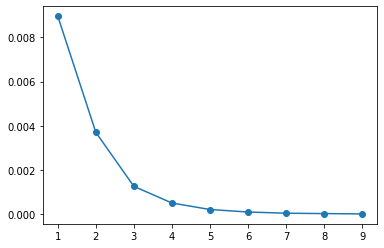

In [50]:
gym_cluster = gym_df.drop('Neighborhood',1)
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(gym_cluster)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,10), wcss, marker='o')


In [52]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++').fit(gym_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 2, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1,
       0, 1, 1, 0])

In [54]:
gym_df['Cluster labels'] = kmeans.labels_
gym_df.head()

(92, 3)


C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Neighborhood  Gym / Fitness Center  Cluster labels
0  Aarey Milk Colony              0.055556               2
1           Agripada              0.000000               1
2     Altamount Road              0.010309               0
3             Amboli              0.011628               0
4        Amrut Nagar              0.000000               1

In [55]:
gym_df = gym_df.join(df.set_index('Neighborhood'), on='Neighborhood')
print(gym_df.shape)
gym_df.head()

(92, 6)


Neighborhood  Gym / Fitness Center  Cluster labels  \
0  Aarey Milk Colony              0.055556               2   
1           Agripada              0.000000               1   
2     Altamount Road              0.010309               0   
3             Amboli              0.011628               0   
4        Amrut Nagar              0.000000               1   

                    Location   Latitude  Longitude  
0   Goregaon,Western Suburbs  19.148493  72.881756  
1               South Mumbai  18.977700  72.827300  
2               South Mumbai  18.968100  72.809500  
3    Andheri,Western Suburbs  19.129300  72.843400  
4  Ghatkopar,Eastern Suburbs  19.102077  72.912835

#### Let's visualize the resulting clusters

In [56]:
# create map
mg_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.2)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map

for lat, lon, neigh, cluster in zip(gym_df['Latitude'], gym_df['Longitude'], gym_df['Neighborhood'], gym_df['Cluster labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mg_clusters)
       
mg_clusters

### Examine Clusters

In [57]:
gym_df.loc[gym_df['Cluster labels'] == 0]

Neighborhood  Gym / Fitness Center  \
2                                 Altamount Road              0.010309   
3                                         Amboli              0.011628   
5                                         Asalfa              0.010000   
8                                   Bangur Nagar              0.020000   
11                                    Bhuleshwar              0.010000   
12                                  Breach Candy              0.010000   
14                               Carmichael Road              0.010000   
15                                         Cavel              0.010000   
17                                    Chandivali              0.010000   
19                                       Chembur              0.013333   
20                                  Chira Bazaar              0.010000   
22                                    Churchgate              0.010000   
25                                  Cumbala Hill              0.010000   
26                                   Currey Road              0.010000   
27                                    D.N. Nagar              0.020000   
30                                   Dava Bazaar              0.010000   
31                                        Deonar              0.012346   
32                                       Dharavi              0.010000   
33                                    Dhobitalao              0.010000   
37                                Four Bungalows              0.020000   
39                                  Gowalia Tank              0.010000   
40                           Hiranandani Gardens              0.012346   
41                                   I.C. Colony              0.012821   
42  Indian Institute of Technology Bombay campus              0.015152   
43                                          Irla              0.020000   
45                                          Juhu              0.020000   
46                                    Kala Ghoda              0.010000   
49                                  Kemps Corner              0.010000   
50                                    Khar Danda              0.010000   
51                                      Kherwadi              0.010000   
52                                   Lokhandwala              0.010000   
53                                   Lower Parel              0.010000   
54                                     Mahalaxmi              0.013889   
60                                  Marine Drive              0.010000   
61                                  Marine Lines              0.010000   
63                                       Matunga              0.010000   
65                                Mumbai Central              0.010000   
69                                 Nariman Point              0.010000   
72                                     Pali Hill              0.010000   
73                                     Pali Naka              0.010000   
74                                    Pant Nagar              0.017857   
75                                         Parel              0.010000   
77                                    Prabhadevi              0.010000   
79                               Seven Bungalows              0.010000   
80                                          Sion              0.010526   
81                                  Sunder Nagar              0.010000   
82                                Thakur village              0.015873   
83                                         Thane              0.010526   
86                                    Vidyavihar              0.010000   
88                                    Vile Parle              0.020000   
91                                         Worli              0.010204   

    Cluster labels                         Location   Latitude  Longitude  
2                0                     South Mumbai  18.968100  72.809500  
3                0          Andheri

In [58]:
gym_df.loc[gym_df['Cluster labels'] == 1]

Neighborhood  Gym / Fitness Center  Cluster labels  \
1              Agripada                   0.0               1   
4           Amrut Nagar                   0.0               1   
6        Ballard Estate                   0.0               1   
7   Bandstand Promenade                   0.0               1   
9               Bhandup                   0.0               1   
10            Bhayandar                   0.0               1   
13        C.G.S. colony                   0.0               1   
16     Chakala, Andheri                   0.0               1   
21          Chor Bazaar                   0.0               1   
23         Cotton Green                   0.0               1   
24         Cuffe Parade                   0.0               1   
28          Dagdi Chawl                   0.0               1   
34             Dindoshi                   0.0               1   
35               Dongri                   0.0               1   
36           Fanas Wadi                   0.0               1   
38                Gorai                   0.0               1   
44      Jogeshwari West                   0.0               1   
47               Kalina                   0.0               1   
48           Kanjurmarg                   0.0               1   
56                Mahim                   0.0               1   
57                Mahul                   0.0               1   
58         Malabar Hill                   0.0               1   
59             Mankhurd                   0.0               1   
62                Marol                   0.0               1   
66                Nahur                   0.0               1   
67              Naigaon                   0.0               1   
68           Nalasopara                   0.0               1   
70           Navy Nagar                   0.0               1   
71          Nehru Nagar                   0.0               1   
78                Sahar                   0.0               1   
84                Uttan                   0.0               1   
87             Vikhroli                   0.0               1   
89                Virar                   0.0               1   
90           Walkeshwar                   0.0               1   

                           Location   Latitude  Longitude  
1                      South Mumbai  18.977700  72.827300  
4         Ghatkopar,Eastern Suburbs  19.102077  72.912835  
6                 Fort,South Mumbai  18.950000  72.840000  
7            Bandra,Western Suburbs  19.042718  72.819132  
9                   Eastern Suburbs  19.140000  72.930000  
10   Mira-Bhayandar,Western Suburbs  19.290000  72.850000  
13          Antop Hill,South Mumbai  19.016378  72.856629  
16                  Western Suburbs  19.111388  72.860833  
21         Kamathipura,South Mumbai  18.960321  72.827176  
23                     South Mumbai  18.986209  72.844076  
24                     South Mumbai  18.910000  72.810000  
28             Byculla,South Mumbai  18.977129  72.829131  
34            Malad,Western Suburbs  19.176382  72.864891  
35                     South Mumbai  19.283333  72.783333  
36           Kalbadevi,South Mumbai  18.951811  72.825309  
38  Borivali (West),Western Suburbs  19.250057  72.782021  
44                  Western Suburbs  19.120000  72.850000  
47       Sanctacruz,Western Suburbs  19.081667  72.841389  
48                  Eastern Suburbs  19.130000  72.940000  
56                     South Mumbai  19.035000  72.840000  
57          Trombay,Harbour Suburbs  19.000000  72.883333  
58                     South Mumbai  18.950000  72.795000  
59                  Harbour Suburbs  19.050000  72.930000  
62          Andheri,Western Suburbs  19.119219  72.882743  
66           Mulund,Eastern Suburbs  19.157000  72.941000  
67            Vasai,Western Suburbs  19.351467  72.846343  
68            Vasai,Western Suburbs  19.415400  72.861300  
70              Colaba,South Mumbai  18.901200  72.8101

In [59]:
gym_df.loc[gym_df['Cluster labels'] == 2]

Neighborhood  Gym / Fitness Center  Cluster labels  \
0   Aarey Milk Colony              0.055556               2   
18            Charkop              0.040000               2   
29             Dahisa              0.034483               2   
55      Mahavir Nagar              0.025974               2   
64          Mira Road              0.029412               2   
76             Poisar              0.025316               2   
85            Versova              0.030000               2   

                          Location   Latitude  Longitude  
0         Goregaon,Western Suburbs  19.148493  72.881756  
18  Kandivali West,Western Suburbs  19.216182  72.830575  
29                 Western Suburbs  19.250069  72.859347  
55  Kandivali West,Western Suburbs  19.211319  72.842737  
64  Mira-Bhayandar,Western Suburbs  19.284167  72.871111  
76  Kandivali West,Western Suburbs  19.204511  72.837639  
85         Andheri,Western Suburbs  19.120000  72.820000

### Observations:

Most of the Gyms/Fitness Center are concentrated in the South Mumbai, with the highest number in cluster 2 which is mostly the western suburbs of Mumbai and moderate number in cluster 0. On the other hand, cluster 1 has very low number to totally no Gyms/Fitness Center in the neighborhoods. This represents a great opportunity and high potential areas to open new Gyms as there is no competition from the existing Gyms. Therefore, this project recommends property developers to capitalize on these findings to open new Gyms/Fitness Center in neighborhoods in cluster 1 with little to no competition. Property developers with unique selling propositions to stand out from the competition can also open new Gyms/Fitness Center in neighborhoods in cluster 0 with moderate competition. Lastly, property developers are advised to avoid neighborhoods in cluster 2 which already have high concentration of shopping malls and suffering from intense competition.